# Classify architecture type from an image of a home

Idea with this project is to classify architecture type from an image of a home

- maybe look at geographic trends in home type?
- not sure exactly.

Here are the types we're are using for classification:
1. prairie-style (prairie)
2. Queen Anne victorian (victorian)
3. Chicago bungalow (bungalow)
4. American foursquare (foursquare)


In [60]:
## IMPORTANT!!!
# for this to work you need to run `PYTORCH_ENABLE_MPS_FALLBACK=1 jupyter notebook` before loading this notebook
# there is an error that pops up later with augmentation that I couldn't figure out how to change while in the
# notebook.

# setup and loading

# to avoid warning of PyTorch
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# fastai V1 library which sits on top of Pytorch 1.0
from fastai.vision import *

import requests

from bs4 import BeautifulSoup

from fastai.vision.all import *
from fastai.vision import *

## Get redfin listings

In [ ]:
# other data?
# look at how (selling?) price of homes is affected by the way it's described
# would be cool if I can do image analysis on homes to classify actual architectural style

main_url = "https://www.redfin.com/IL/Oak-Park/613-S-Grove-Ave-60304/home/13249167"

# Getting individual cities url
# re = requests.get(main_url)
# soup = BeautifulSoup(re.text, "html.parser")
# soup

# NB this failed because they think it's a bot

In [5]:
# let's try something else
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:78.0)   Gecko/20100101 Firefox/78.0", 
"Referer": "https://www.google.com"}

response = requests.get(main_url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")
soup
# this works!


In [30]:
# now I need to find out how to extract data...
soup.contents

['html',
 <html lang="en"><head>
 <script charset="UTF-8" data-domain-script="7e5bc3d6-ef20-4760-aa0d-c8df4649fae2" src="https://cdn.cookielaw.org/scripttemplates/otSDKStub.js" type="text/javascript"></script>
 <script>
 			window.__uspapi = function (command, version, callback) {
 				callback({}, false);
 			}
 		</script>
 <!-- Server: phantom-205 --><!-- Time generated: Thu Sep 05 2024 09:15:02 GMT-0700 (Pacific Daylight Time) --><script>(function(a){window.__reactServerOnClickHandler=function(i){(a[i]=a[i]||[]).push(window.event)}})(window.__reactServerUnhandledEvents={})</script><title>613 S grove Ave, Oak Park, IL 60304 | MLS# 10311124 | Redfin</title><link data-href="CopBpWidgets~493df0b3.e82c88fa0f8eb5668e0b.styles.css" data-react-server-css="" href="https://ssl.cdn-redfin.com/vLATEST/corvstatic/customer-pages/CopBpWidgets~493df0b3.e82c88fa0f8eb5668e0b.styles.css" media="" rel="stylesheet" type="text/css"/><link data-href="bp-long-cache~df5f41f1.783188cbc49c0cb8d8c7.styles.css

## House image classifier

## Sources for verified images

- prairie style - https://www.localarchitecturechicago.com/index.php/2019/09/13/prairie-architecture-in-chicagos-beverly-and-morgan-park-neighborhoods-1904-1925/
- bungalow - https://www.chicagobungalow.org/chicago-bungalow
- general - https://www.oldhouses.com/styleguide

### Image loading setup

In [63]:
path = "/Users/chad/github/architecture/images"
fnames = get_image_files(path)
len(fnames)

65

In [4]:
import re

# create a label function
def label_func(f):
    return f[0].isupper()

# pat = r'^(.*)_.+\.jpg'

# Since it’s pretty common to use regular expressions to label the data (often, labels are hidden in the file names), there is a factory method to do just that:


### Use image augmentation to increase training samples

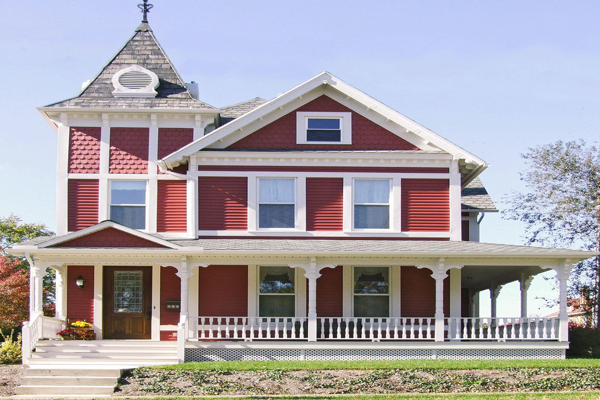

In [6]:
# single image of a house
img = PILImage(PILImage.create(fnames[0]).resize((600,400)))
img

In [7]:
# tensor.. ?
timg = TensorImage(array(img)).permute(2,0,1).float()/255.

In [135]:
# setup augmentation transforms of image
tfms = aug_transforms(pad_mode='zeros', mult=2, min_scale=0.75, do_flip=True, flip_vert=False, max_rotate=3, max_zoom=1.1,
                     max_lighting=0.2, max_warp=0.1, p_affine=0.75, p_lighting=0.5)

# NB: I took these parameters from an existing project on github-
# https://github.com/dumitrux/architectural-style-recognition/blob/master/src/architectural-style-recognition.ipynb
# tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, 
#                       max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
# NB: this get_transforms function is for the old fastai/pytorch versions so now I needed to use aug_transforms, as above


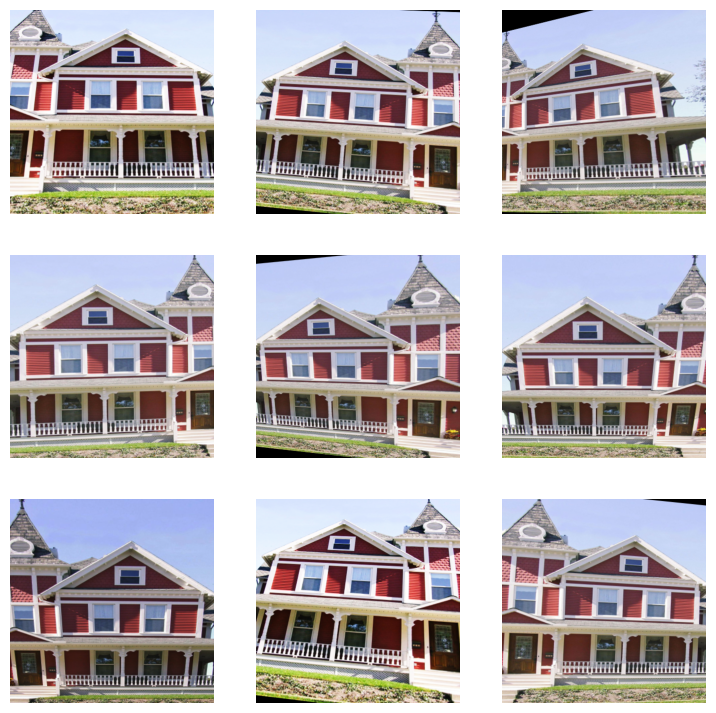

In [136]:
# TODO figure out what this function is doing!
def _batch_ex(bs):
    return TensorImage(timg[None].expand(bs, *timg.shape).clone())

# plot some sample transformations
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)

In [137]:
# this way was using cap letter as labeler
# dls = ImageDataLoaders.from_name_func(path, files, label_func, bs=5, item_tfms=Resize(224), valid_pct=0.2)
# valid_pct is the percent of images used for validation

# this pulls the label from the file name (stuff before _ or -)
# dls = ImageDataLoaders.from_name_re(path, files, pat='^(.*)[_-].*?.jpg', item_tfms=Resize(224), bs=5)

# trying datablock instead
# here the subfolder name is used as the label
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(valid_pct=0.2, seed=44),
                   item_tfms = Resize(224),
                   batch_tfms = tfms)

# does this help anything?
# batch_tfms = aug_transforms(size=224)
# load the data (batch size 5 minimum)
dls = dblock.dataloaders(path, bs=12)

In [138]:
'train:', len(dls.train.items), 'valid:', len(dls.valid.items)

('train:', 52, 'valid:', 13)

In [139]:
print("Training images:\n", [x.stem for x in dls.train.items], "\n")
print("Validation images:\n", [x.stem for x in dls.valid.items])

Training images:
 ['red-victorian-home-wrap-around-porch-964fcce8-6d2ab8ee6f5b4d79941bd8866d1fb9ec', 'detroitbungalow_edited', 'prairie_410NElmwoodAve', '5E39127F-AA2D-456F-BB60-D3AC619AE854', 'StuccoFourSquare', 'bungalow-484149133', '001-1024x680', 'GettyImages-160808926-8259f31f8e924329bf7bc59c0f6e89dc', 'XL_21561_Jones_Listing_201_Market_Street_Bvillle_013', 'Foursquare_1016ElginAve', 'prairie_1624W100thPl', 'main3', 'Foursquare-613SGrove', 'Foursquare_330SLombardAve', 'chicagobungalow4', 'mqa946mcv8m61', '674b8fda13b2840a27e796dc69f82254', '2449FourSquare', 'XL_16916_Front', 'prairie_1712W104thPl', 'GettyImages-165432736-scaled', 'victorian_654NCentralAve', 'main4_prairie-1024x768', '2928FourSquare', 'bungalow_1218Rossell', 'chicagobungalow8', 'Stock-Small-Bungalow-Home-Exterior-AdobeStock_361162520-copy', 'portland-foursquare-home', 'chicagobungalow3', 'stuccobungalow2', 'Foursquare_724SElmwoodAve', '6891-prairie-style-home-chicago', 'americanfoursquare', 'bungalow_932NOakParkAve

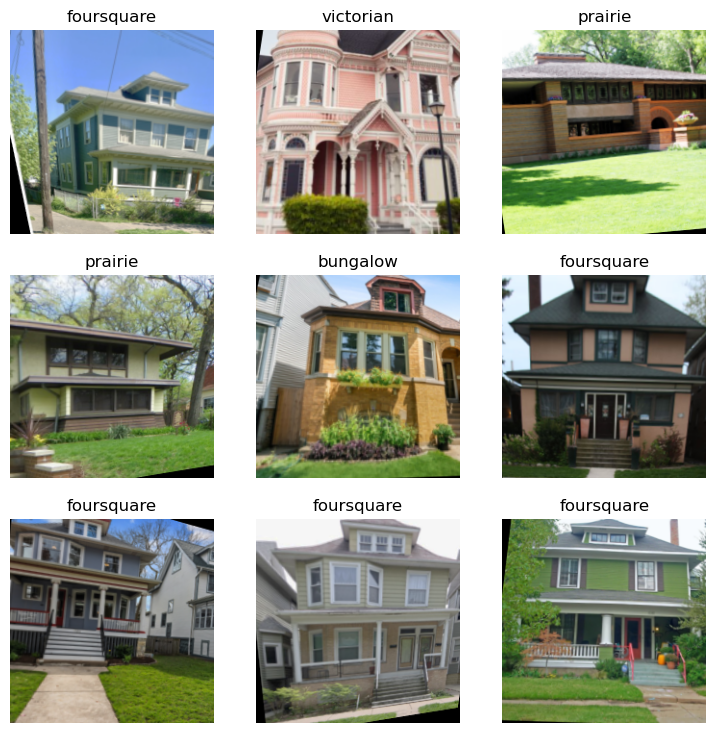

In [140]:
dls.show_batch()

In [141]:
# train the model
learn = vision_learner(dls, resnet34, metrics=error_rate)

# NB this was using ~6 cores on my local machine (macbook)

SuggestedLRs(valley=0.0030199517495930195)

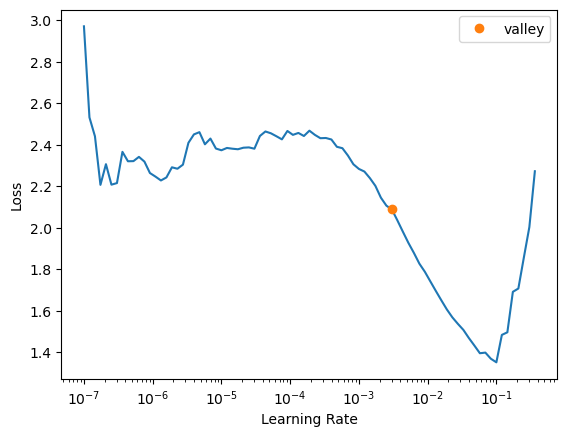

In [142]:
# ?? find optimal parameters for fine-tuning the model
learn.lr_find()

In [143]:
# fine tune the learner
learn.fine_tune(15, 0.003)

In [ ]:
# decent performance (~85% accuracy) with only this very limited image set

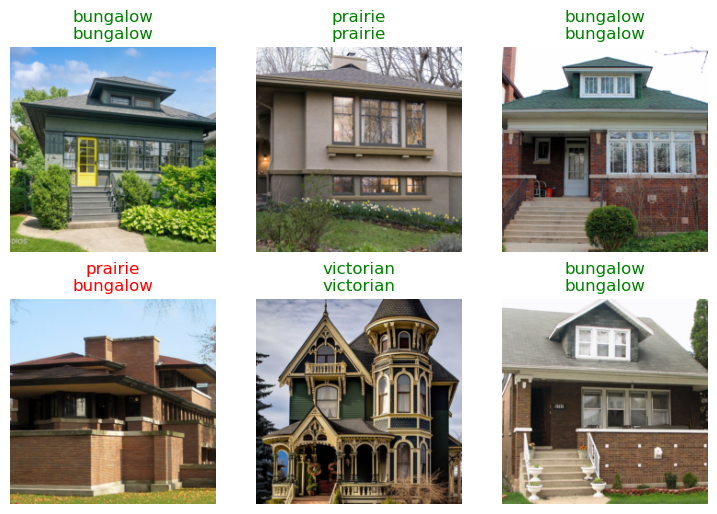

In [144]:
learn.show_results(max_n=6)

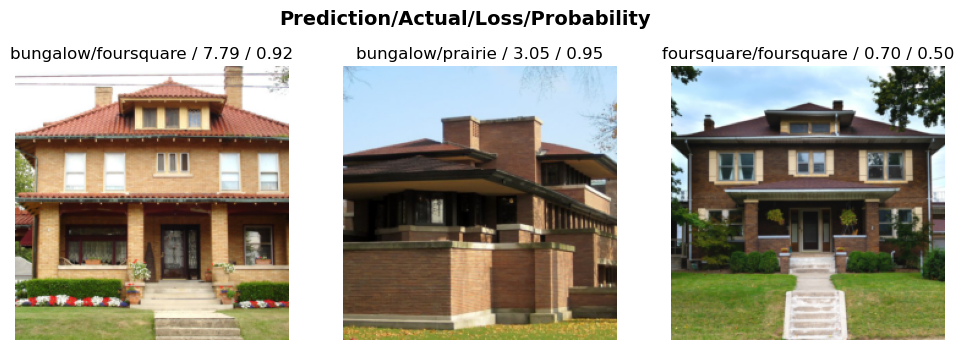

In [145]:
# find the images that give the most problems
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(3, figsize=(12,4))

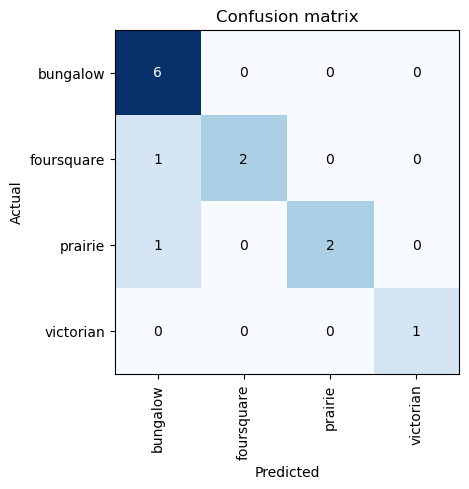

In [146]:
# look at confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

From this, we can see that bungalows, foursquares, and prairie-style homes all kind of blend together.

## Use the model to predict redfin images

## Create map of architectural diversity by block